In [1]:
library(ggplot2)
library(data.table)
theme_set(theme_bw())

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘data.table’ was built under R version 4.2.3”


In [2]:
tools = c('singlem', 'metaphlan', 'motus', 'kraken', 'sourmash', 'kaiju', 'map2b', 'metabuli')
# Tools that do not have the correct taxonomy are tested only at the domain level. eg. Kaiju has NCBI taxonomy and MAP2B uses GTDB v202, mOTUs sometimes has incompatible strings
correct_taxonomy_tools = c('singlem', 'metaphlan', 'kraken', 'sourmash', 'metabuli')

publication_names = data.table(
    tool = tools,
    publication_name = c('SingleM', 'MetaPhlAn', 'mOTUs', 'Kraken2', 'sourmash', 'Kaiju', 'MAP2B', 'Metabuli')
)
name_to_publication_name = function(names, correct_taxonomy_only=F){
    to_return = c()
    for (name in names){
        to_return = c(to_return, publication_names[tool==name]$publication_name)
    }
    if (correct_taxonomy_only){
        return(factor(to_return, levels=publication_names[tool %in% correct_taxonomy_tools]$publication_name))
    } else {
        return(factor(to_return, levels=publication_names$publication_name))
    }
}

In [3]:
setwd('~/m/msingle/mess/124_singlem-benchmarking/1_novel_strains/')
base_dir = './'
# base_dir = 'full_run8/checkout/1_novel_strains/' # Directory created when run in local scratch through queuing system

In [4]:
communities = gsub('^','marine',as.character(0:9))
# communities = gsub('^','marine',as.character(6)) # debug
communities

[1] "marine0" "marine1" "marine2" "marine3" "marine4" "marine5" "marine6"
 [8] "marine7" "marine8" "marine9"

In [5]:
d1 = data.table(expand.grid(correct_taxonomy_tools, communities))
setnames(d1, c('tool', 'community'))
d1[1:3]

tool,community
<fct>,<fct>
singlem,marine0
metaphlan,marine0
kraken,marine0


In [6]:
# output_singlem/opal/GCA_022615805.1_genomic.opal_report
readit = function(tool, community){
    to_read = paste(base_dir,'output_',tool,sep='','/opal/',community,'.opal_report')
    # print(to_read)
    return(fread(to_read))
}
d2 = d1[, readit(tool, community), by=list(tool,community)]
d2[1:3]

tool,community,tool,rank,metric,sample,value
<fct>,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>
singlem,marine0,Gold standard,kingdom,Bray-Curtis distance,SAMPLEID,0
singlem,marine0,Gold standard,phylum,Bray-Curtis distance,SAMPLEID,0
singlem,marine0,Gold standard,class,Bray-Curtis distance,SAMPLEID,0


In [7]:
dim(d2)

[1] 9100    7

In [8]:
setnames(d2, c('tool','community','blah','rank','metric','sample','value'))
d3 = d2[blah != 'Gold standard'][,.(tool, community, rank, metric, value)]
d3[1:3]
dim(d3)

tool,community,rank,metric,value
<fct>,<fct>,<chr>,<chr>,<dbl>
singlem,marine0,kingdom,Bray-Curtis distance,0.001959197
singlem,marine0,phylum,Bray-Curtis distance,0.016112387
singlem,marine0,class,Bray-Curtis distance,0.016821463


[1] 4550    5

In [9]:
fwrite(d3, 'accuracy_results.csv')

In [10]:
bc = d3[metric=='Bray-Curtis distance']
dim(bc)
bc[1:10]

[1] 350   5

tool,community,rank,metric,value
<fct>,<fct>,<chr>,<chr>,<dbl>
singlem,marine0,kingdom,Bray-Curtis distance,0.0019591970
singlem,marine0,phylum,Bray-Curtis distance,0.0161123867
singlem,marine0,class,Bray-Curtis distance,0.0168214633
singlem,marine0,order,Bray-Curtis distance,0.0222182684
singlem,marine0,family,Bray-Curtis distance,0.0289220811
singlem,marine0,genus,Bray-Curtis distance,0.0397711568
singlem,marine0,species,Bray-Curtis distance,0.1650375655
metaphlan,marine0,kingdom,Bray-Curtis distance,0.0003342733
metaphlan,marine0,phylum,Bray-Curtis distance,0.0535211153


In [11]:
orders = c('kingdom','phylum','class','order','family','genus','species')
bc[, rank := factor(rank, levels=orders)]
bc[1:3]

tool,community,rank,metric,value
<fct>,<fct>,<fct>,<chr>,<dbl>
singlem,marine0,kingdom,Bray-Curtis distance,0.001959197
singlem,marine0,phylum,Bray-Curtis distance,0.016112387
singlem,marine0,class,Bray-Curtis distance,0.016821463


In [12]:
average_bc = bc[tool %in% correct_taxonomy_tools][, mean(value), by=list(tool)][order(V1)]
average_bc

tool,V1
<fct>,<dbl>
singlem,0.04414802
metaphlan,0.10842747
kraken,0.16328604
sourmash,0.18170170
metabuli,0.28413137


In [13]:
bcc = bc[tool %in% correct_taxonomy_tools]
bcc[, tool2 := name_to_publication_name(tool, correct_taxonomy_only=T)]

Warning message:
“`qplot()` was deprecated in ggplot2 3.4.0.”
Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”
Warning message:
“Removed 10 rows containing non-finite values (`stat_boxplot()`).”


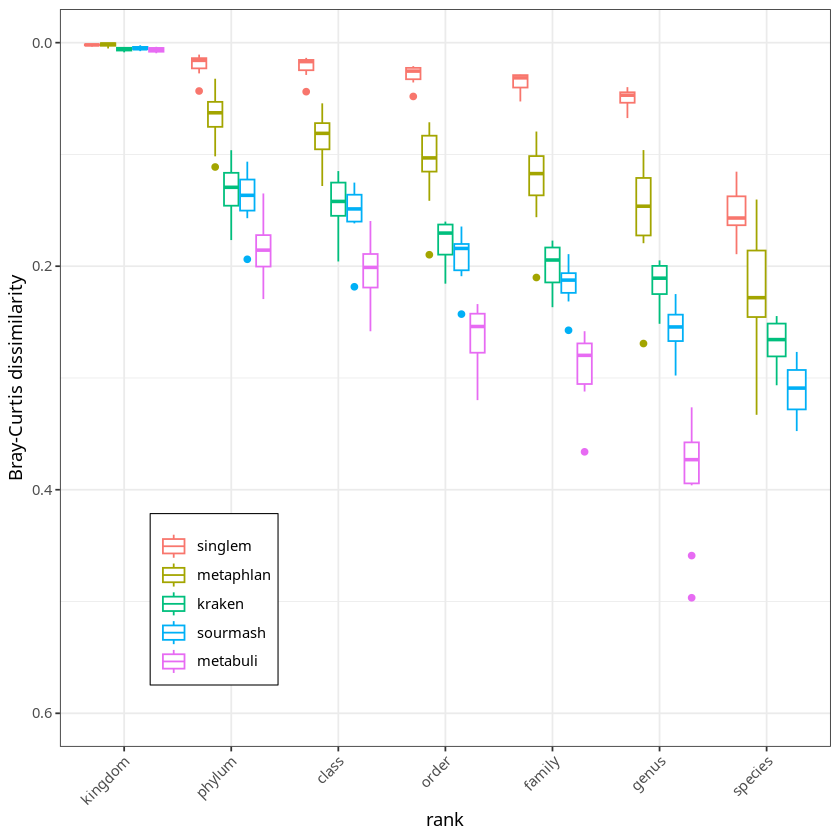

In [14]:

# Remove figure legend title, and put the legend in bottom left of plot, with a bounding box
qplot(data=bcc, rank, value, ylim=c(0.6,0), geom='boxplot', colour=tool, ylab='Bray-Curtis dissimilarity') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.title=element_blank()) + theme(legend.position=c(0.2,0.2)) + theme(legend.background = element_rect(colour = "black", size = 0.3))

tool,V1
<fct>,<dbl>
singlem,0.002131396
metaphlan,0.001895268
kraken,0.005836309
sourmash,0.005035773
metabuli,0.006291923


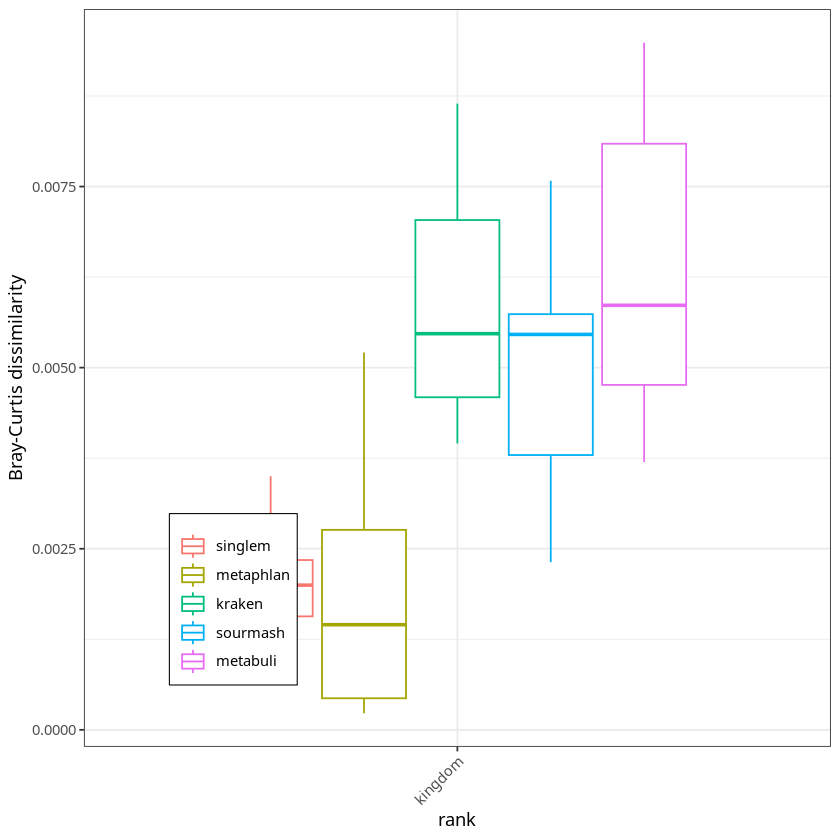

In [15]:
# What is the comparison between tools at the kingdom level specifically?
qplot(data=bcc[rank=='kingdom'], rank, value, geom='boxplot', colour=tool, ylab='Bray-Curtis dissimilarity') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.title=element_blank()) + theme(legend.position=c(0.2,0.2)) + theme(legend.background = element_rect(colour = "black", size = 0.3))
bcc[rank=='kingdom'][,.(mean(value)), by=tool]

In [16]:
# How much better is singlem than the next best tool?
means = bcc[rank=='species', mean(value), by=tool][order(-V1)]
means
means[tool=='singlem', V1] - means[tool!='singlem', min(V1)]

tool,V1
<fct>,<dbl>
metabuli,0.6540856
sourmash,0.3118549
kraken,0.2686295
metaphlan,0.2196410
singlem,0.1517086


[1] -0.06793242

In [17]:
# write out bc
fwrite(bcc, 'bray-curtis.csv', sep='\t')

# Runtime comparison

In [18]:
# thread_numbers = as.character(c(1,8,32))
thread_numbers = as.character(c(1))

In [19]:
# DEBUG - set to 32 threads so to get a preliminary answer
# thread_numbers = c(32)

In [20]:
r1 = data.table(expand.grid(correct_taxonomy_tools, thread_numbers, communities))
setnames(r1, c('tool', 'threads', 'community'))
r1 = r1[tool != 'coverm' | threads == '32']
r1[1:3]

tool,threads,community
<fct>,<fct>,<fct>
singlem,1,marine0
metaphlan,1,marine0
kraken,1,marine0


In [21]:
r1[tool=='kracken', tool := 'kraken']
reed = function(tool,threads,community){
    # print(x)
    # f = paste(base_dir,'benchmarks/',x$tool,'/',x$community,'-',x$threads,'threads.benchmark',sep='')
    f = paste(base_dir,'benchmarks/',tool,'/',community,'-',threads,'threads.benchmark',sep='')
    # print(f)
    return(fread(f))
}
r2 = r1[, reed(tool,threads,community), by=list(tool,threads,community)]
getwd()
r2[1:3]

[1] "/mnt/hpccs01/work/microbiome/msingle/mess/124_singlem-benchmarking/1_novel_strains"

tool,threads,community,s,h:m:s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time
<fct>,<fct>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
singlem,1,marine0,2095.2530,0:34:55,2118.18,4199.02,2099.82,2101.65,5165.68,577.93,89.76,1906.17
metaphlan,1,marine0,22857.8442,6:20:57,17510.76,18019.95,17469.80,17484.95,7914.11,116.59,99.50,22742.44
kraken,1,marine0,991.0659,0:16:31,294865.69,294878.02,294860.20,294860.44,23511.73,0.01,92.02,912.79


In [22]:
r2[,.(minutes=mean(s/60), minutes_sd=sd(s/60), mean_mem = mean(max_rss), sd_mem = sd(max_rss)), by=list(tool,threads)]

tool,threads,minutes,minutes_sd,mean_mem,sd_mem
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
singlem,1,34.01210,1.882585,1959.425,106.20725
metaphlan,1,368.65571,26.710622,17522.942,13.00121
kraken,1,17.35564,1.211712,294877.120,52.33779
sourmash,1,48.81879,7.089642,2634.133,209.32424
metabuli,1,291.03687,19.703385,120776.288,9286.11877


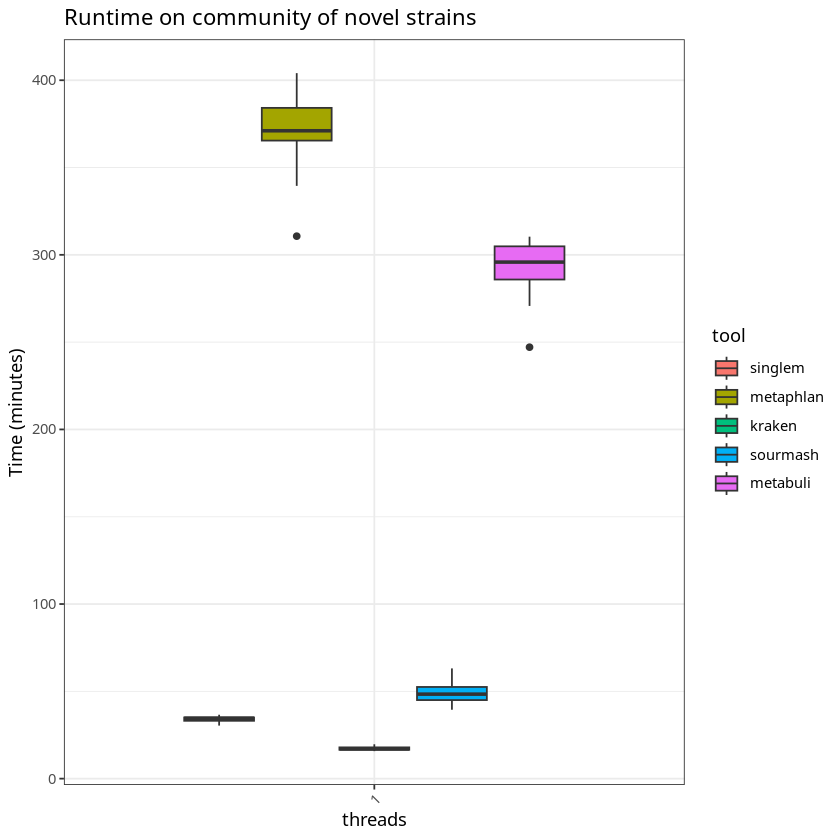

In [23]:
qplot(data=r2, threads, s/60, geom='boxplot', fill=tool, ylab='Time (minutes)', main='Runtime on community of novel strains') + theme(axis.text.x = element_text(angle = 45, hjust = 1))

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


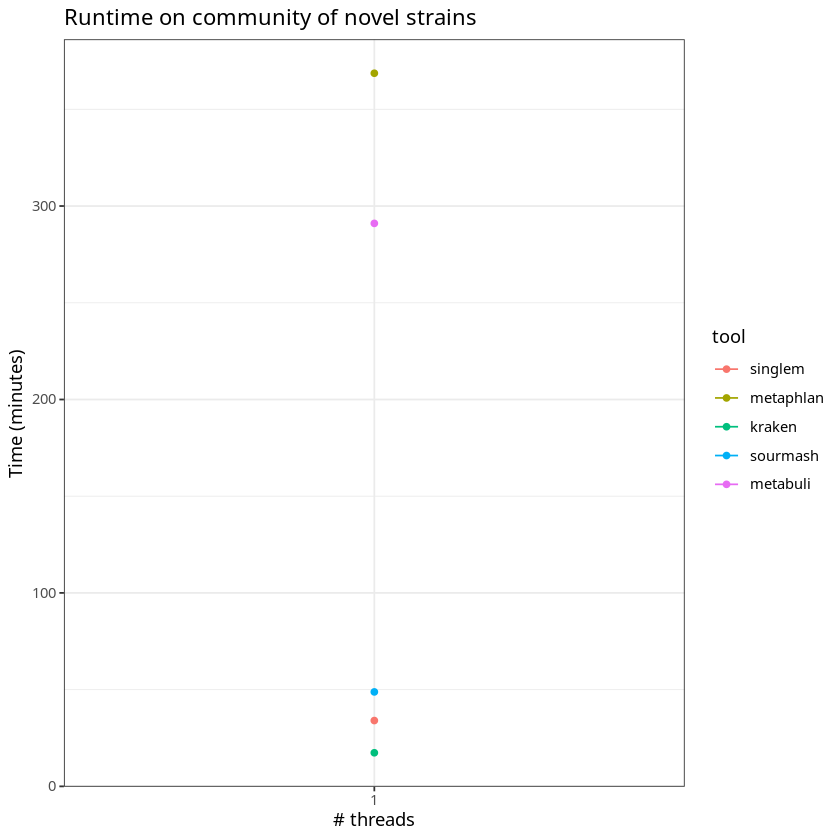

In [24]:
r3 = r2[, .(mean_s = mean(s)), by=list(tool,threads)]
# r3
qplot(data=r3, as.numeric(threads), mean_s/60, geom='point', ylab='Time (minutes)', xlab='# threads', main='Runtime on community of novel strains', colour=tool)+geom_line()+scale_x_continuous(breaks=c(1,2,3), labels=c(1,8,32))

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


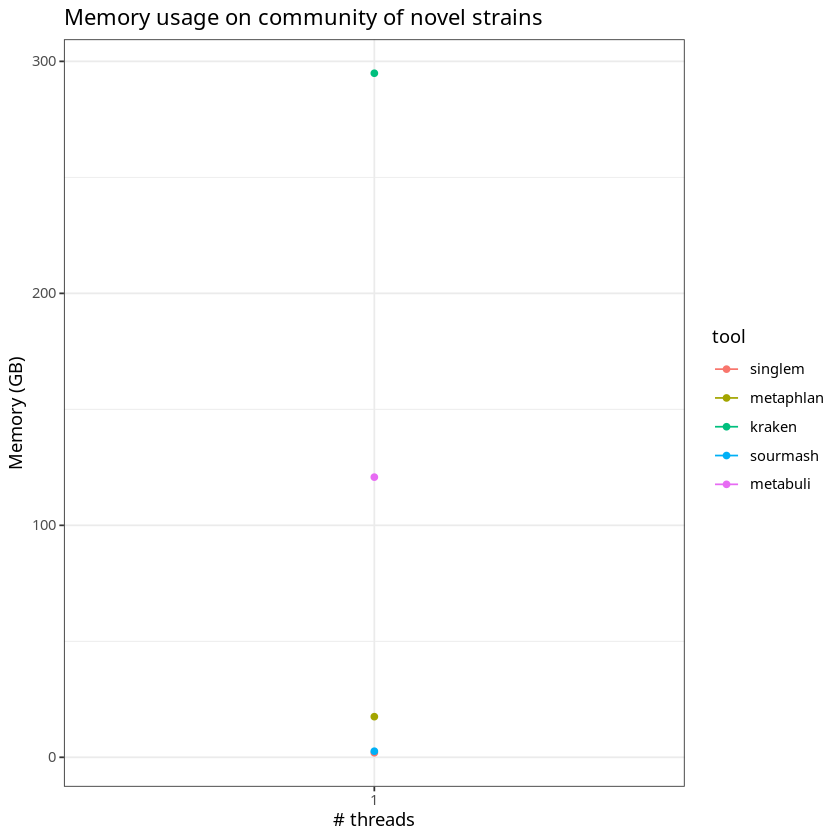

In [25]:
# RAM
r4 = r2[, .(mean_mem = mean(max_rss)), by=list(tool,threads)]
qplot(data=r4, as.numeric(threads), mean_mem/1000, geom='point', ylab='Memory (GB)', xlab='# threads', main='Memory usage on community of novel strains', colour=tool)+geom_line()+scale_x_continuous(breaks=c(1,2,3), labels=c(1,8,32))

In [26]:
r4

tool,threads,mean_mem
<fct>,<fct>,<dbl>
singlem,1,1959.425
metaphlan,1,17522.942
kraken,1,294877.120
sourmash,1,2634.133
metabuli,1,120776.288


In [27]:
## Commented out because it takes a while to run

# Reads per minute
# read_counts = data.table(community=communities)
# read_counts2 = read_counts[, fread(cmd=paste('zcat local_reads/',community,'.1.fq.gz | wc -l',sep='')), by=community]
# read_counts2

# rcm = merge(r2[threads==1], read_counts2, by='community')
# rcm[, rpm := (V1/4)/s*60 *2] # times 2 because we only have half the reads in count
# rcm[1:3]

In [28]:
# Write rc3
fwrite(r2, 'runtime.csv', sep='\t')

In [30]:
r2[1:3]

tool,threads,community,s,h:m:s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time
<fct>,<fct>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
singlem,1,marine0,2095.2530,0:34:55,2118.18,4199.02,2099.82,2101.65,5165.68,577.93,89.76,1906.17
metaphlan,1,marine0,22857.8442,6:20:57,17510.76,18019.95,17469.80,17484.95,7914.11,116.59,99.50,22742.44
kraken,1,marine0,991.0659,0:16:31,294865.69,294878.02,294860.20,294860.44,23511.73,0.01,92.02,912.79


In [34]:
# Write for supp data
fwrite(
    r2[threads==1, .(community, tool=name_to_publication_name(tool), runtime_seconds=s, max_rss)],
    'runtimes_readable.csv')

# Full set of stats of each method

In [30]:
s1 = dcast(d3, tool+rank~metric, value.var='value', fun.aggregate=mean)

s1 = s1[tool %in% correct_taxonomy_tools]
s1[, tool2 := name_to_publication_name(tool, correct_taxonomy_only=T)]
s1[, tool := tool2]
s1[, tool2 := NULL]

# dcast(d3[metric %in% non_ranked_metrics], tool~metric, value.var='value', fun.aggregate=mean)

s1[, rank := factor(rank, levels=orders)]
s1 = s1[order(rank, tool)]
s1[1:3]
fwrite(s1, 'opal_summary.csv', sep='\t')

tool,rank,Bray-Curtis distance,Completeness,F1 score,False negatives,False positives,Jaccard index,L1 norm error,Purity,Shannon diversity,Shannon equitability,Sum of abundances,Taxon counts,True positives,Unweighted UniFrac (CAMI),Unweighted UniFrac error,Weighted UniFrac (CAMI),Weighted UniFrac error
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SingleM,kingdom,0.002131396,1,1,0,0,1,0.004262791,1,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN
MetaPhlAn,kingdom,0.001895268,1,1,0,0,1,0.003790535,1,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN
Kraken2,kingdom,0.005836309,1,1,0,0,1,0.011672618,1,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN


# Relationship between relative abundance and accuracy

In [31]:
base = base_dir #'/mnt/hpccs01/work/microbiome/msingle/mess/124_singlem-benchmarking/1_novel_strains/full_run1/checkout/1_novel_strains/'
# base = './'

truth_profiles = data.table(community=communities)
truth_profiles2 = truth_profiles[, fread(paste(base,'/truths/',community,'.condensed',sep='')), by=community]
truth_profiles2[, sample := NULL]
setnames(truth_profiles2, 'coverage', 'true_coverage')

tool_profiles = data.table(expand.grid(correct_taxonomy_tools, communities))
setnames(tool_profiles, c('tool','community'))
tool_profiles2 = tool_profiles[, fread(paste(base,'/output_',tool,'/',tool,'/',community,'.profile',sep='')), by=list(tool,community)]
tool_profiles2[, sample := NULL]
setnames(tool_profiles2, 'coverage', 'tool_coverage')
tool_profiles2[, taxonomy := gsub('Root;','',gsub('; ',';',taxonomy))]

# Kraken has filled profiles, so remove all except species annotations
tool_profiles3 = rbind(
    tool_profiles2[tool != 'kraken'],
    tool_profiles2[tool == 'kraken' & taxonomy %like% 's__']
)
tool_profiles3[tool=='kraken'][1:5]
# cartesian product so the all = T works for each tool
community_tool = data.table(expand.grid(tools, communities))
setnames(community_tool, c('tool','community'))
truth_profiles3 = merge(truth_profiles2, community_tool, all=T, allow.cartesian=T)
# truth_profiles3

m = merge(truth_profiles3, tool_profiles3, by=c('taxonomy','community','tool'), all=T)

m[is.na(tool_coverage), tool_coverage := 0]
m[is.na(true_coverage), true_coverage := 0]

tool,community,tool_coverage,taxonomy
<fct>,<fct>,<dbl>,<chr>
kraken,marine0,0.04247,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas_E;s__Pseudomonas_E soli
kraken,marine0,0.02729,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas_E;s__Pseudomonas_E sp019139675
kraken,marine0,0.00434,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas_E;s__Pseudomonas_E sp003013355
kraken,marine0,0.00411,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas_E;s__Pseudomonas_E lactis
kraken,marine0,0.00405,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas_E;s__Pseudomonas_E mosselii


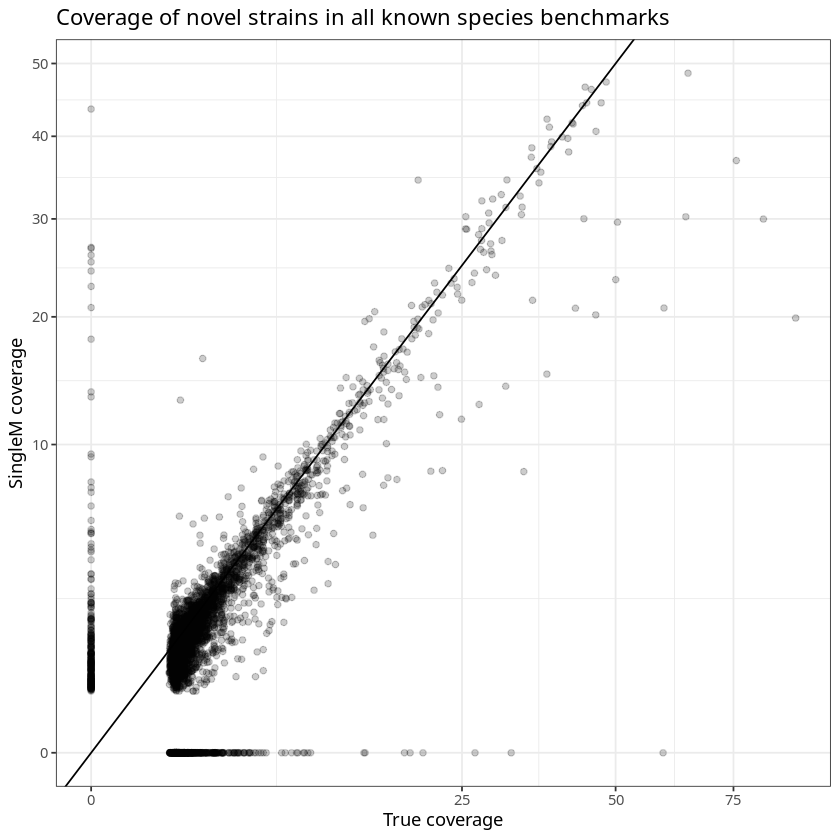

In [32]:
# Just for SingleM
qplot(data=m[tool=='singlem' & tool_coverage < 50][grep('s__',taxonomy)], true_coverage, tool_coverage, geom='point', xlab='True coverage', ylab='SingleM coverage', main='Coverage of novel strains in all known species benchmarks', alpha=I(1/5)) + geom_abline(intercept=0, slope=1)+scale_x_sqrt()+scale_y_sqrt()

In [33]:
m[tool=='kraken'][grep('s__',taxonomy)][community=='marine6'][order(-tool_coverage)][1:3]

taxonomy,community,tool,true_coverage,tool_coverage
<chr>,<fct>,<fct>,<dbl>,<dbl>
d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Kluyvera;s__Kluyvera intermedia,marine6,kraken,63.7534,0.05042
d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Rhizobium;s__Rhizobium sophoriradicis,marine6,kraken,37.7800,0.03883
d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Burkholderiaceae;g__Paraburkholderia;s__Paraburkholderia terricola,marine6,kraken,23.9494,0.02666


# Read in ANI of each shadow genome to GTDB reps

In [34]:
shadow_anis = fread('../reference_genomes/shadow_vs_gtdb.skani.csv', sep='\t')
shadow_anis = shadow_anis[ANI>90][,.(
    rep=gsub('_genomic.*','', gsub('.*/','',Ref_file)),
    shadow=gsub('.fna','', gsub('.*/','',Query_file)),
    ANI,
    Align_fraction_query
)]
shadow_anis = shadow_anis[order(-ANI)][, .SD[1], by=shadow]
dim(shadow_anis)
shadow_anis[1:3]
stopifnot(nrow(shadow_anis) == 3000)

[1] 3000    4

shadow,rep,ANI,Align_fraction_query
<chr>,<chr>,<dbl>,<dbl>
GCA_002210125.1,GCF_002797755.1,100,100.00
GCA_016860585.1,GCA_016860565.1,100,99.00
GCA_900753675.1,GCA_900549975.1,100,83.68


In [35]:
communities = gsub('^','marine',as.character(0:9))
# communities = gsub('^','marine',as.character(6)) # debug
communities_df = data.table(community=communities)
communities_df

community
<chr>
marine0
marine1
marine2
marine3
marine4
marine5
marine6
marine7
marine8


In [36]:
# Read the genome-wise from each community
genomewise_communities = communities_df[,fread(paste('truths/',community,'.genomewise.csv',sep='')), by=community]
genomewise_communities[1:3]
dim(genomewise_communities)

community,accession,coverage,fasta,taxonomy
<chr>,<chr>,<dbl>,<chr>,<chr>
marine0,RS_GCF_001953075.1,2.12834,/mnt/hpccs01/work/microbiome/msingle/mess/124_singlem-benchmarking/reference_genomes/shadow/GCF_001953075.1.fna,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Halieaceae;g__Halioglobus;s__Halioglobus lutimaris
marine0,RS_GCF_003815695.1,1.83878,/mnt/hpccs01/work/microbiome/msingle/mess/124_singlem-benchmarking/reference_genomes/shadow/GCF_003815695.1.fna,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Weeksellaceae;g__Chryseobacterium;s__Chryseobacterium carnipullorum
marine0,RS_GCF_013321855.1,2.42345,/mnt/hpccs01/work/microbiome/msingle/mess/124_singlem-benchmarking/reference_genomes/shadow/GCF_013321855.1.fna,d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Rhizobiaceae;g__Rhizobium;s__Rhizobium rhizogenes


[1] 4694    5

In [37]:
highest_per_community = genomewise_communities[order(-coverage)][,.SD[1],by=list(community,taxonomy)]
dim(highest_per_community)

[1] 4556    5

In [38]:
highest_per_community[, shadow := gsub('^.._','',accession)]
shadow_merge = merge(highest_per_community[,.(community,shadow,taxonomy)], shadow_anis, by='shadow')
shadow_merge[1:3]

shadow,community,taxonomy,rep,ANI,Align_fraction_query
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
GCA_000191565.1,marine4,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Weeksellaceae;g__Riemerella;s__Riemerella anatipestifer,GCF_000252855.1,99.59,98.33
GCA_000191565.1,marine6,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Weeksellaceae;g__Riemerella;s__Riemerella anatipestifer,GCF_000252855.1,99.59,98.33
GCA_000191565.1,marine7,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Weeksellaceae;g__Riemerella;s__Riemerella anatipestifer,GCF_000252855.1,99.59,98.33


In [39]:
# All tools
# First convert to relabund
m[, tool_coverage_relabund := tool_coverage/sum(tool_coverage)*100, by=list(tool, community)]
m[, true_coverage_relabund := true_coverage/sum(true_coverage)*100, by=list(tool, community)]

m = m[tool %in% correct_taxonomy_tools]
m[, tool2 := name_to_publication_name(tool, correct_taxonomy_only=T)]


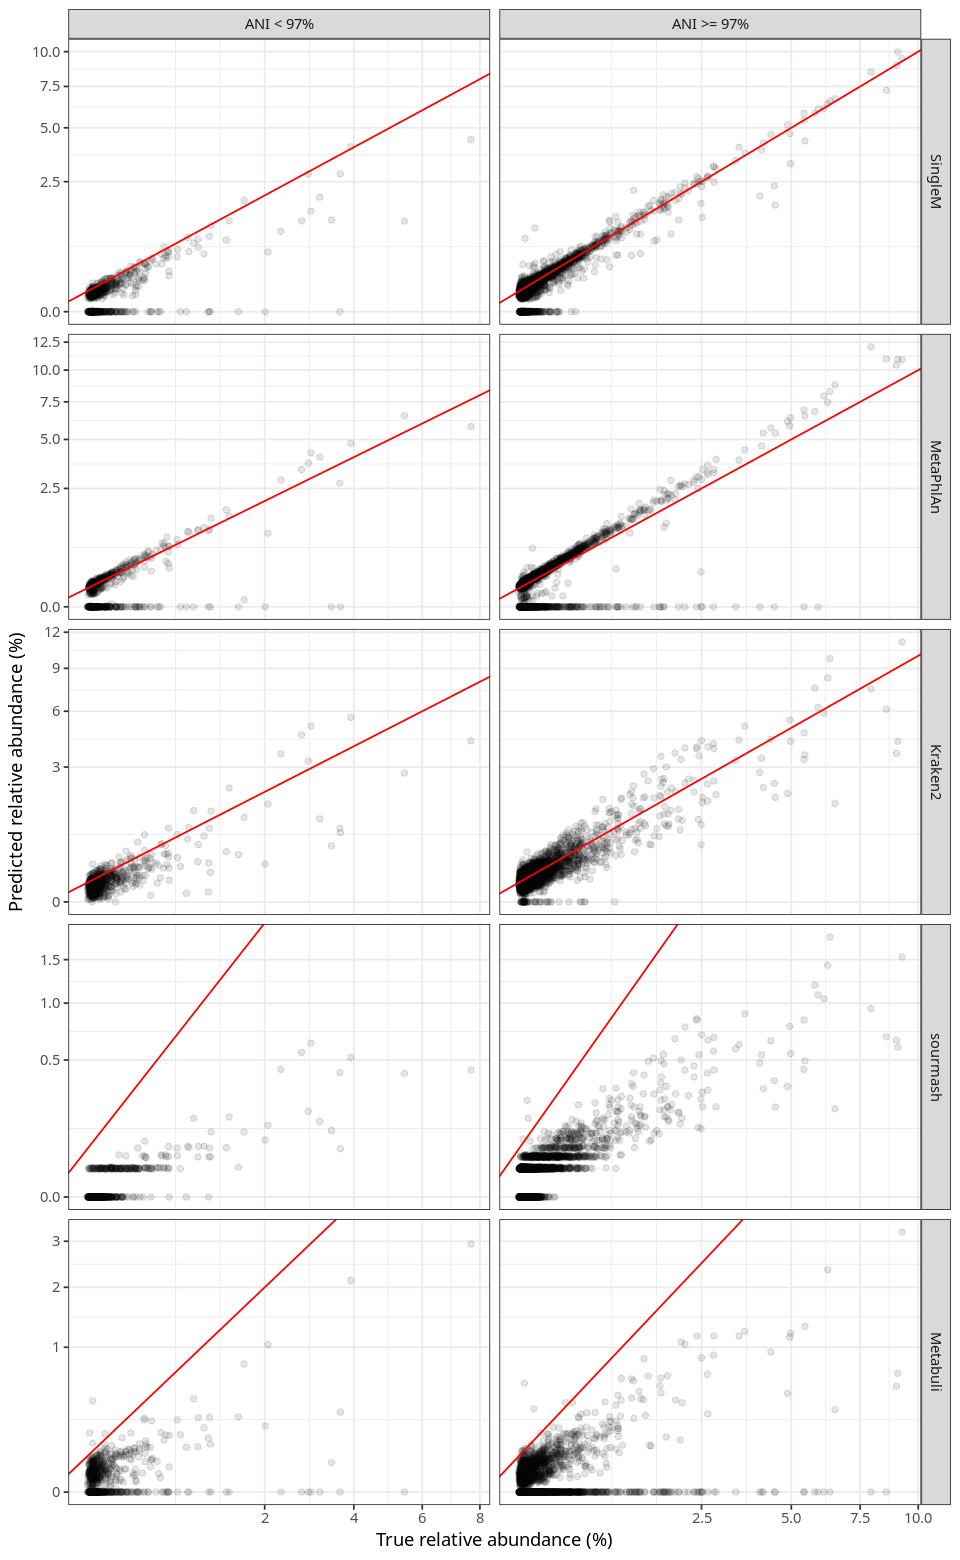

In [40]:
m_species = m[grep('s__',taxonomy)]
shadow_merge[, taxonomy := gsub('; ',';', taxonomy)]

shadow_merge[, com_tax := paste(community, taxonomy)]
m_species[, com_tax := paste(community, taxonomy)]

m_species2 = merge(m_species, shadow_merge[,.(com_tax, ANI)], by='com_tax')

original_width_height = c(getOption('repr.plot.width'), getOption('repr.plot.height'))
options(repr.plot.width=8, repr.plot.height=13)

m_species2[, ANI98_str := 'ANI < 97%']
m_species2[ANI >= 97, ANI98_str := 'ANI >= 97%']

qplot(data=m_species2, true_coverage_relabund, tool_coverage_relabund, geom='point', xlab='True relative abundance (%)', ylab='Predicted relative abundance (%)', alpha=I(1/10)) + geom_abline(intercept=0, slope=1, colour='red')+scale_x_sqrt()+scale_y_sqrt()+facet_grid(tool2~ANI98_str, scales='free')
options(repr.plot.width=original_width_height[1], repr.plot.height=original_width_height[2])

In [41]:
# Quantify outside of 98% for SingleM
m_species2[tool2=='SingleM'][,.(mean(sqrt((true_coverage-tool_coverage)**2))), by=ANI<98]

ANI,V1
<lgl>,<dbl>
FALSE,0.6678166
TRUE,1.5055592


In [42]:
# What's with the 20+ coverage genome?

# marine0 = fread(paste(base,'truths/marine0.condensed',sep=''))
# marine0[, sample := 'marine0']
# setnames(marine0, 'coverage', 'true_coverage')
# singlem_marine0 = fread(paste(base,'output_singlem/singlem/marine0.profile',sep=''))
# setnames(singlem_marine0, 'coverage', 'singlem_coverage')
# singlem_marine0[, taxonomy := gsub('Root;','',gsub('; ',';',taxonomy))]
# # singlem_marine0[grep('s__',taxonomy)][1:3]

# m[true_coverage > 20 & singlem_coverage ==0]
# singlem_marine0[grep('g__Pseudomonas_E',taxonomy)]
# # => So it backed off to species level for some reason. Unsure why.

In [43]:
# Fraction of genomes which were missed at each binned coverage levels
# m[, .(missed = sum(singlem_coverage==0)/.N*100, .N), by=.(cut(true_coverage, breaks=c(0,2,4,6,8,10,20,40,1000)))][order(cut)]

In [44]:
# How well does genus level rescue some of the missing genomes? First need to remake the table with genus level, annoying since kraken profiles are filled, when the rest aren't.

# Kraken has filled profiles, so remove all except species annotations
tool_profiles3_genus = rbind(
    tool_profiles2[tool != 'kraken'],
    tool_profiles2[tool == 'kraken' & taxonomy %like% 'g__']
)
tool_profiles3_genus[tool=='kraken'][1:5]

m_genus = merge(truth_profiles3, tool_profiles3_genus, by=c('taxonomy','community','tool'), all=T)

m_genus[is.na(tool_coverage), tool_coverage := 0]
m_genus[is.na(true_coverage), true_coverage := 0]

m_genus[1:3]

m_genus[, genus_and_up := gsub(';s__.*','',taxonomy)]

# m[grep('g__',taxonomy)][1:10]
m2_genus = m_genus[, .(tool_coverage=sum(tool_coverage), true_coverage=sum(true_coverage)), by=.(community, genus_and_up, tool)]

m2_genus[grep('g__',genus_and_up)][tool=='kraken' & true_coverage > 0][1:3]

tool,community,tool_coverage,taxonomy
<fct>,<fct>,<dbl>,<chr>
kraken,marine0,0.14711,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas_E
kraken,marine0,0.00449,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas
kraken,marine0,0.00404,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas_A
kraken,marine0,0.00232,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas_F
kraken,marine0,0.00002,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas_R


taxonomy,community,tool,true_coverage,tool_coverage
<chr>,<fct>,<fct>,<dbl>,<dbl>
d__Archaea,marine0,singlem,0,1.1800
d__Archaea,marine0,sourmash,0,0.0050
d__Archaea,marine0,metabuli,0,0.5483


community,genus_and_up,tool,tool_coverage,true_coverage
<fct>,<chr>,<fct>,<dbl>,<dbl>
marine0,d__Archaea;p__Halobacteriota;c__Archaeoglobi;o__Archaeoglobales;f__JdFR-42;g__JdFR-42,kraken,0.00039,1.18832
marine1,d__Archaea;p__Halobacteriota;c__Archaeoglobi;o__Archaeoglobales;f__JdFR-42;g__JdFR-42,kraken,0.00056,1.67278
marine2,d__Archaea;p__Halobacteriota;c__Archaeoglobi;o__Archaeoglobales;f__JdFR-42;g__JdFR-42,kraken,0.00047,1.45378


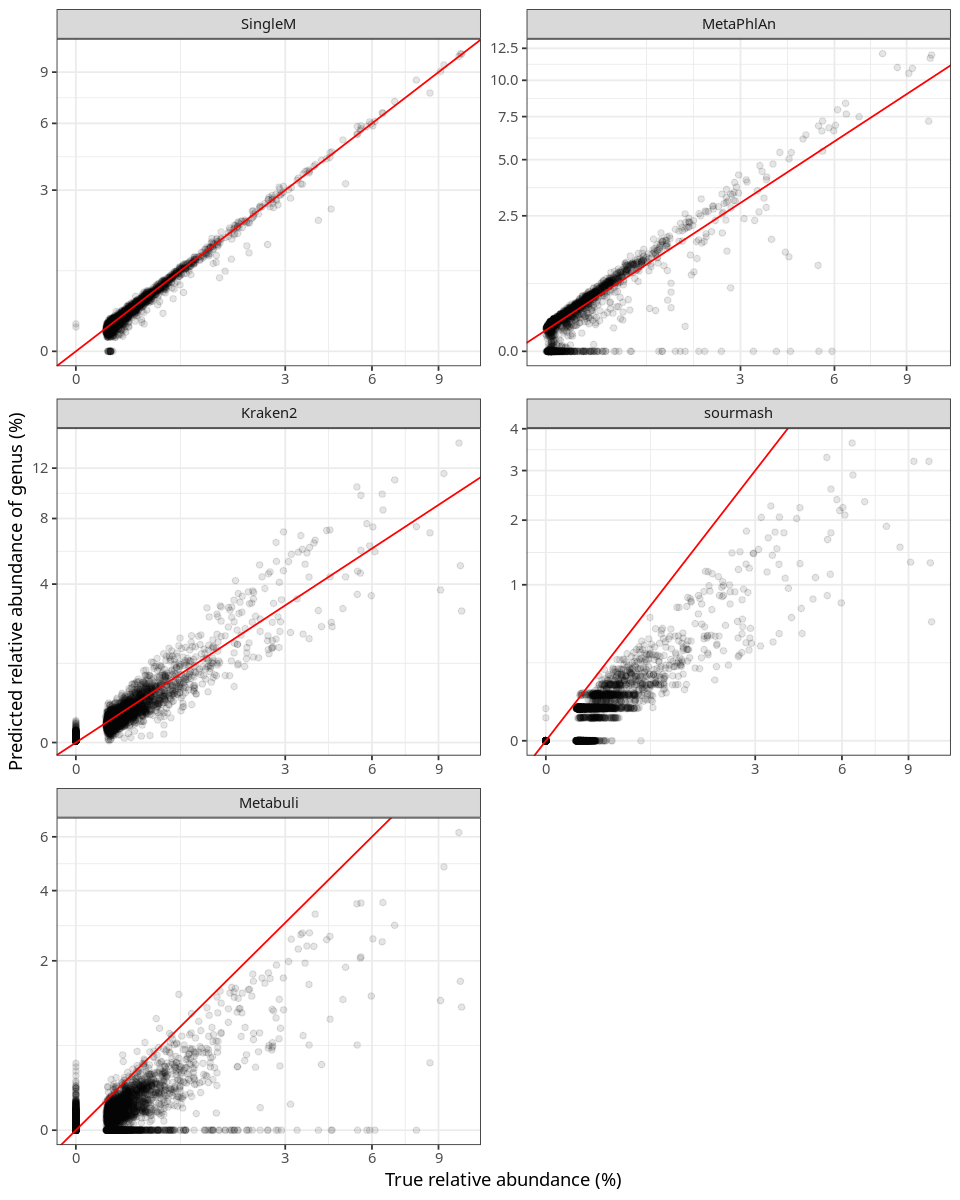

In [45]:
m2_genus[, tool_coverage_relabund := tool_coverage/sum(tool_coverage)*100, by=list(tool, community)]
m2_genus[, true_coverage_relabund := true_coverage/sum(true_coverage)*100, by=list(tool, community)]

m2_genus = m2_genus[tool %in% correct_taxonomy_tools]
m2_genus[, tool2 := name_to_publication_name(tool, correct_taxonomy_only=T)]

original_width_height = c(getOption('repr.plot.width'), getOption('repr.plot.height'))
options(repr.plot.width=8, repr.plot.height=10)
qplot(data=m2_genus[grep('g__',genus_and_up)], true_coverage_relabund, tool_coverage_relabund, geom='point', xlab='True relative abundance (%)', ylab='Predicted relative abundance of genus (%)', alpha=I(1/10)) + geom_abline(intercept=0, slope=1, colour='red')+scale_x_sqrt()+scale_y_sqrt()+facet_wrap(~tool2, ncol=2, scales='free')
options(repr.plot.width=original_width_height[1], repr.plot.height=original_width_height[2])

`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


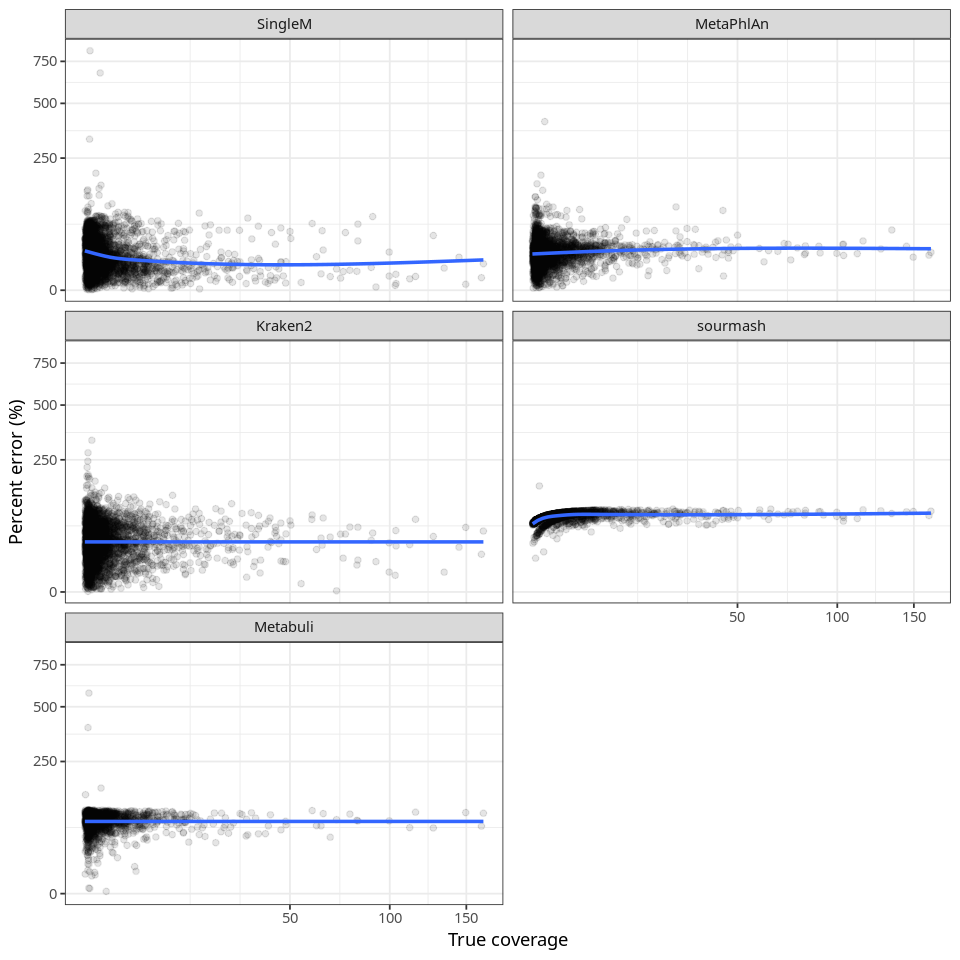

In [46]:
# Percent error at the species level for each tool
# m[1:3]
m_error = m_species[true_coverage>0 & tool_coverage>0]
m_error[, error := abs(true_coverage_relabund - tool_coverage_relabund)/true_coverage_relabund*100]

options(repr.plot.width=8, repr.plot.height=8)
qplot(data=m_error, true_coverage, error, geom='point', xlab='True coverage', ylab='Percent error (%)', alpha=I(1/10))+scale_x_sqrt()+scale_y_sqrt()+facet_wrap(~tool2, ncol=2)+geom_smooth(se=F)

# What fraction of singlem profiles are assigned to the species level?

In [47]:
# m
assigned = m[tool2=='SingleM'][,sum(.SD[grep('s__',taxonomy)]$tool_coverage_relabund),by=community]
assigned
mean(assigned$V1)
sd(assigned$V1)

community,V1
<fct>,<dbl>
marine0,87.35601
marine1,85.79491
marine2,88.84567
marine3,84.51480
marine4,89.17267
marine5,86.05649
marine6,88.02810
marine7,87.99291
marine8,89.61659


[1] 87.42403

[1] 1.629001

# How many species are in each gold standard?

In [48]:
coverages = data.table(number=0:9)
coverages2 = coverages[, fread(paste('coverage_definitions/coverage',number,'.tsv',sep='')), by=number]
setnames(coverages2, c('number','genome','coverage'))
mean(coverages2[grep('Otu',genome)][coverage>0][,.N,by=number]$N)
coverages2[grep('Otu',genome)][coverage>0]

[1] 469.4

number,genome,coverage
<int>,<chr>,<dbl>
0,Otu520.0,2.12834
0,Otu634.0,1.83878
0,Otu483,2.42345
0,Otu2487,1.56681
0,Otu2446,1.33722
0,Otu980,3.43963
0,Otu1219,1.34402
0,Otu2448,2.10658
0,Otu489.0,1.57037


# Actual coverage estimation investigation

In [49]:
# What is the reason for the lower F1 score (really completeness) of SingleM on CAMI ?

# Take marine7 as an example
# Read gold standard condensed
gs = fread('truths/marine7.condensed')[order(-coverage)]
gs[, taxonomy := gsub(';','; ',taxonomy)]
sm = fread('output_singlem/singlem/marine7.profile')[order(-coverage)]
gs[1:3]

sm_species = sm[grep('s__', taxonomy)][order(-coverage)]
sm_species[1:3]

sample,coverage,taxonomy
<chr>,<dbl>,<chr>
coverage7.tsv,134.5270,d__Bacteria; p__Firmicutes_B; c__Desulfotomaculia; o__Desulfotomaculales; f__Pelotomaculaceae; g__Pelotomaculum_C; s__Pelotomaculum_C schinkii
coverage7.tsv,92.0649,d__Bacteria; p__Actinobacteriota; c__Actinomycetia; o__Nanopelagicales; f__CAIYMF01; g__WLRQ01; s__WLRQ01 sp903918645
coverage7.tsv,75.6696,d__Bacteria; p__Firmicutes_A; c__Clostridia; o__Lachnospirales; f__Lachnospiraceae; g__RGIG1934; s__RGIG1934 sp017396555


sample,coverage,taxonomy
<chr>,<dbl>,<chr>
marine7.1,134.13,Root; d__Bacteria; p__Firmicutes_B; c__Desulfotomaculia; o__Desulfotomaculales; f__Pelotomaculaceae; g__Pelotomaculum_C; s__Pelotomaculum_C schinkii
marine7.1,85.90,Root; d__Bacteria; p__Actinobacteriota; c__Actinomycetia; o__Nanopelagicales; f__CAIYMF01; g__WLRQ01; s__WLRQ01 sp903918645
marine7.1,36.91,Root; d__Bacteria; p__Firmicutes_A; c__Clostridia; o__Lachnospirales; f__Lachnospiraceae; g__RGIG1934; s__RGIG1934 sp017396555


In [50]:
# Take marine7 as an example
# Read gold standard condensed
gs = fread('truths/marine7.condensed')[order(-coverage)]
gs[, taxonomy := gsub(';','; ',taxonomy)][, taxonomy := gsub('^','Root; ',taxonomy)]
sm = fread('output_singlem/singlem/marine7.profile')[order(-coverage)]
gs[1:3]

sm_species = sm[grep('s__', taxonomy)][order(-coverage)]
sm_species[1:3]

sample,coverage,taxonomy
<chr>,<dbl>,<chr>
coverage7.tsv,134.5270,Root; d__Bacteria; p__Firmicutes_B; c__Desulfotomaculia; o__Desulfotomaculales; f__Pelotomaculaceae; g__Pelotomaculum_C; s__Pelotomaculum_C schinkii
coverage7.tsv,92.0649,Root; d__Bacteria; p__Actinobacteriota; c__Actinomycetia; o__Nanopelagicales; f__CAIYMF01; g__WLRQ01; s__WLRQ01 sp903918645
coverage7.tsv,75.6696,Root; d__Bacteria; p__Firmicutes_A; c__Clostridia; o__Lachnospirales; f__Lachnospiraceae; g__RGIG1934; s__RGIG1934 sp017396555


sample,coverage,taxonomy
<chr>,<dbl>,<chr>
marine7.1,134.13,Root; d__Bacteria; p__Firmicutes_B; c__Desulfotomaculia; o__Desulfotomaculales; f__Pelotomaculaceae; g__Pelotomaculum_C; s__Pelotomaculum_C schinkii
marine7.1,85.90,Root; d__Bacteria; p__Actinobacteriota; c__Actinomycetia; o__Nanopelagicales; f__CAIYMF01; g__WLRQ01; s__WLRQ01 sp903918645
marine7.1,36.91,Root; d__Bacteria; p__Firmicutes_A; c__Clostridia; o__Lachnospirales; f__Lachnospiraceae; g__RGIG1934; s__RGIG1934 sp017396555


Warning message:
“Removed 59 rows containing missing values (`geom_point()`).”


Warning message:
“Removed 61 rows containing missing values (`geom_point()`).”


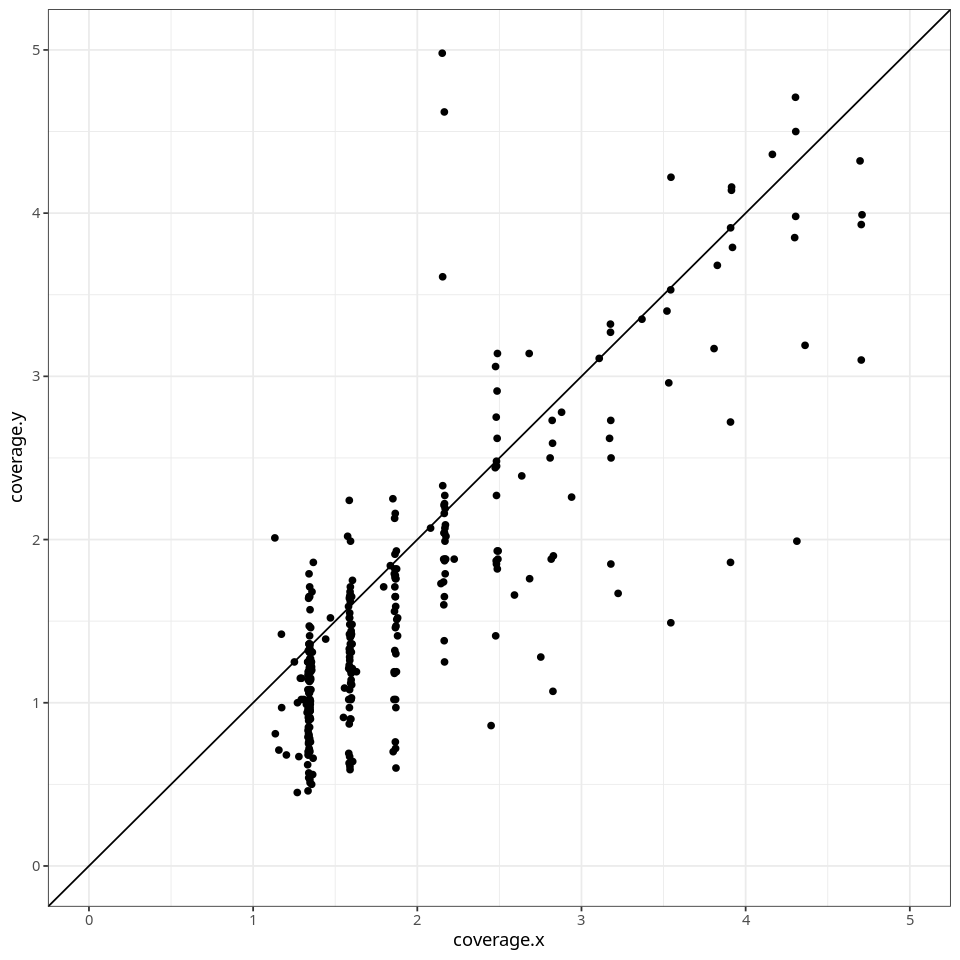

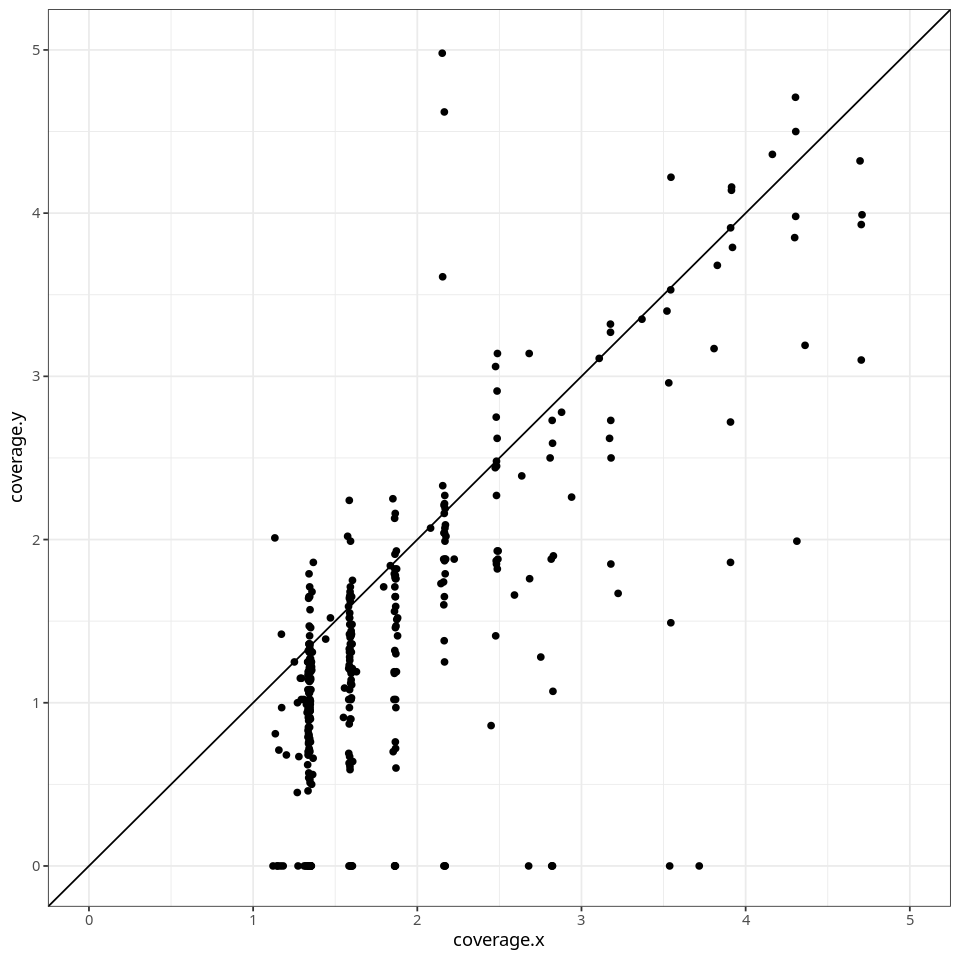

In [51]:
# So just a coverage thing?
qplot(data=merge(gs, sm_species, by='taxonomy'), coverage.x, coverage.y)+geom_abline(intercept=0, slope=1)+xlim(c(0,5))+ylim(c(0,5))
m = merge(gs, sm_species, by='taxonomy', all.x=T)
m[is.na(coverage.y), coverage.y := 0]
qplot(data=m, coverage.x, coverage.y)+geom_abline(intercept=0, slope=1)+xlim(c(0,5))+ylim(c(0,5))

# What does 0.35X coverage align to in terms of percent, for low abundance filtering?

In [52]:
mean_total_coverage = mean(truth_profiles2[, sum(true_coverage), by=community]$V1)

mean_total_coverage
0.35 / mean_total_coverage * 100

[1] 1704.973

[1] 0.02052818

# Removing low abundance species improves things?

In [76]:
low_completeness = data.table(expand.grid(community=communities, tool_in=correct_taxonomy_tools))
low_completeness = low_completeness[,fread(paste('output_',tool_in,'/opal_low_abund/',community,'.opal_report', sep=''), sep='\t'), by=list(community,tool_in)]
low_completeness[1:3]

community,tool_in,tool,rank,metric,sample,value
<fct>,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>
marine0,singlem,Gold standard,kingdom,Bray-Curtis distance,SAMPLEID,0
marine0,singlem,Gold standard,phylum,Bray-Curtis distance,SAMPLEID,0
marine0,singlem,Gold standard,class,Bray-Curtis distance,SAMPLEID,0


In [88]:
lc = low_completeness[tool!='Gold standard'][,.(value=mean(value)), by=list(metric,rank,tool_in)]
lc[, rank := factor(rank, levels=c('species','genus','family','order','class','phylum','kingdom'))]
lc[, tool2 := name_to_publication_name(tool_in, correct_taxonomy_only = T)]
# lc
# dcast(lc, rank+tool2~metric, value.var='value')
fwrite(x=dcast(lc, rank+tool2~metric, value.var='value'), file='supp_data_low_abundance.csv')

# Write overall results for supp data

In [89]:
d3w = d3[tool!='Gold standard'][,.(value=mean(value)), by=list(tool,metric,rank)]
d3w[, rank := factor(rank, levels=c('species','genus','family','order','class','phylum','kingdom'))]
d3w[, tool2 := name_to_publication_name(tool, correct_taxonomy_only = T)]
# dcast(d3w, rank+tool2~metric, value.var='value')
fwrite(x=dcast(d3w, rank+tool2~metric, value.var='value'), file='supp_data1.csv')

rank,tool2,Bray-Curtis distance,Completeness,F1 score,False negatives,False positives,Jaccard index,L1 norm error,Purity,Shannon diversity,Shannon equitability,Sum of abundances,Taxon counts,True positives,Unweighted UniFrac (CAMI),Unweighted UniFrac error,Weighted UniFrac (CAMI),Weighted UniFrac error
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,SingleM,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1080.800,0.3141952,0.5945851,0.004316515
NA,MetaPhlAn,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,610.900,0.1519636,1.5179845,0.012074273
NA,Kraken2,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,23534.882,6.7857297,2.2528426,0.019238814
NA,sourmash,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1268.239,0.3360598,2.5138747,0.021104033
NA,Metabuli,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,39035.513,11.3076682,4.0645722,0.031615241
species,SingleM,0.151708618,0.8666762,0.90286533,61.1,24.2,0.82303018,0.284093163,0.94237504,4.554180,0.7553079,0.8742403,418.7,394.5,NA,NA,NA,NA
species,MetaPhlAn,0.219641036,0.7899343,0.84222159,96.0,39.0,0.72745909,0.439282073,0.90195543,5.041924,0.8429739,1.0000000,398.6,359.6,NA,NA,NA,NA
species,Kraken2,0.268629470,0.9876311,0.24243429,5.7,2799.2,0.13807864,0.534133069,0.13832283,5.589754,0.6913880,0.9883210,3249.1,449.9,NA,NA,NA,NA
species,sourmash,0.311854903,0.5904509,0.73178403,187.8,9.6,0.57797986,0.601512477,0.96482708,4.634174,0.8243845,0.9289396,277.4,267.8,NA,NA,NA,NA


# Best performance in each category above species level

In [38]:
fwrite(d3[rank != 'species'][,mean(value),by=list(tool,metric)][order(metric,V1)])

tool,metric,V1
singlem,Bray-Curtis distance,0.0262212512897523
metaphlan,Bray-Curtis distance,0.0898918708615723
kraken,Bray-Curtis distance,0.14572880337797
sourmash,Bray-Curtis distance,0.160009495996787
metabuli,Bray-Curtis distance,0.222472342531933
sourmash,Completeness,0.763206875242464
metabuli,Completeness,0.868982501776278
metaphlan,Completeness,0.886584130376802
kraken,Completeness,0.985590147944613
singlem,Completeness,0.996651500517874
metabuli,F1 score,0.536562297214841
kraken,F1 score,0.742071391934547
sourmash,F1 score,0.860757061761034
metaphlan,F1 score,0.939099652030058
singlem,F1 score,0.996307393458229
singlem,False negatives,0.483333333333333
kraken,False negatives,3.15
metaphlan,False negatives,14.45
metabuli,False negatives,24.2833333333333
sourmash,False negatives,34.9166666666667
metaphlan,False positives,0
sourmash,False positives,0.0333333333333333
singlem,False positives,0.2
kraken,False positives,130.916666666667
metabuli,False positives,464.116666666667
me